# Application of the model proposed in Meta's paper "Simple and Controllable Music Generation"

"MUSICGEN, a single Language Model (LM) that operates over several streams of compressed discrete music representation" 

### Challenges with MusicGen

- Modeling Long Range Sequences is difficult
- Signals have to be sampled at a higher rate(44.1KHz to 48KHz vs 16KHz for speech)
- Music conatains complex sturctures 


"To make audio modeling more tractable, recent studies proposed representing
audio signals as multiple streams of discrete tokens representing the same signal. This allows both high-quality audio generation and effective audio modeling. However, this
comes at the cost of jointly modeling several parallel dependent streams."

- MUSICGEN consists in an autoregressive transformer-based decoder, conditioned on a text or melody representation


### Audio Tokenisation  
- MusicGen Utilizes EnCodec, a convolutional auto-encoder with a latent space quantized using Residual Vector Quantization and an adverserial reconstruction loss.

A brief description of RVQ:

In traditional Vector Quantization, a codebook consisting of representative vectors (code vectors) is constructed based on the training data. During encoding, each input vector is approximated by selecting the closest code vector from the codebook. The index of the selected code vector is then transmitted or stored. During decoding, the original vector is reconstructed using the corresponding code vector.

Residual Vector Quantization extends this concept by considering the difference between the original vector and the reconstructed vector (i.e., the residual). Instead of encoding the original vector directly, RVQ encodes the residual vector, which represents the difference between the original vector and its reconstruction. This residual vector tends to have lower entropy than the original vector, resulting in better compression efficiency.

- Given a reference audio random variable X ∈ R
d·fs with d the audio duration and fs the sample
rate, EnCodec encodes it into a continuous tensor with a frame rate fr ≪ fs. This representation is
then quantized into Q ∈ {1, . . . , N}
K×d·fr
, with K being the number of codebooks used in RVQ
and N being the codebook size

- In RVQ, each quantizer encodes
the quantization error left by the previous quantizer, thus quantized values for different codebooks
are in general not independent, and the first codebook is the most important one

### Codebook interleaving patterns

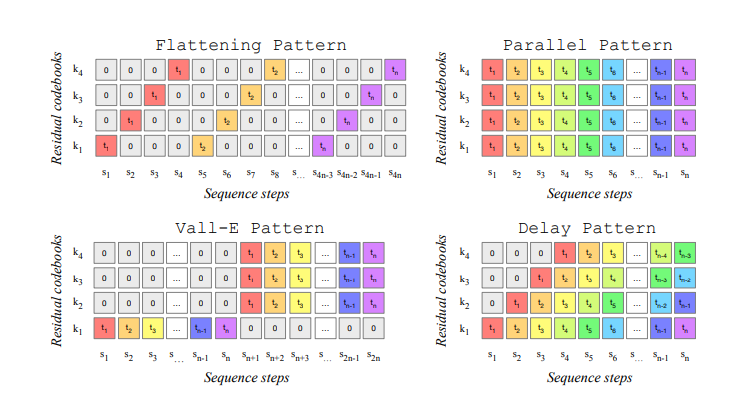

### Model Conditioning

#### Text Conditioning
- Generally there are three main approachs for the representing text for conditoinal audio generation. T5 encoder, FLAN-T5 and CLAP. The model experiments with all of them


#### Melody Conditioning

- The model experiments with controlling the melodic structure via jointly conditioning on the input's chromagram and text description.
- But, conditioning on the raw chromagram often led to reconstructing the original sample, resulting in overfitting.
- To tackle this, this model used an information bottleneck by choosing the dominant time-frequency bin in each time step, but an unsupervised approach was taken


### Model Architecture

#### Codebook projection and positional embedding
"Given a codebook pattern, only some codebooks
are present at each pattern step Ps. We retrieve from Q the values corresponding to the indices in Ps.
Each codebook is present at most once in Ps or not at all. If it is present,
we use a learned embedding table with N entries and dimension D to represent the associated value
from Q. Otherwise, we use a special token indicating its absence. We sum the contribution from each
codebook after this transformation. As P0 = ∅, the first input is always the sum of all the special
tokens. Finally, we sum a sinusoidal embedding to encode the current step s"

#### Transformer Decoder

"The input is fed into a transformer with L layers and a dimension D. Each
layer consists of a causal self-attention block. We then use a cross-attention block that is fed with the
conditioning signal C. When using melody conditioning, we instead provide the conditioning tensor
C as a prefix to the transformer input. The layer ends with a fully connected block consisting of a
linear layer from D to 4·D channels, a ReLU, and a linear layer back to D channels. The attention and
fully connected blocks are wrapped with a residual skip connection. Layer normalization  is applied to each block before being summed with the residual skip connection (“pre-norm”)"

#### Logits Predicition
"The output from the transformer decoder at pattern step Ps is transformed into
logits prediction for the values of Q taken at the indices given by Ps+1. Each codebook is present at
most once in Ps+1. If a codebook is present, the logits prediction is obtained by applying a codebook
specific linear layer from D channels to N"




## Models and Hyperparameters



### Audio Tokenization Model

Uses a non-causal five layers EnCodec model for 32 kHz monophonic
audio with a stride of 640, resulting in a frame rate of 50 Hz, and an initial hidden size of 64, doubling
at each of the model’s five layers. The embeddings are quantized with an RVQ with four quantizers,
each with a codebook size of 2048

### Transformer Model

"We train autoregressive transformer models at different sizes: 300M, 1.5B,
3.3B parameters. We use a memory efficient Flash attention from the xFormers
package to improve both speed and memory usage with long sequences. We
study the impact of the size of the model in Section 4. We use the 300M-parameter model for all of
our ablations. We train on 30-second audio crops sampled at random from the full track. We train
the models for 1M steps with the AdamW optimizer , a batch size of
192 examples, β1 = 0.9, β2 = 0.95, a decoupled weight decay of 0.1 and gradient clipping of 1.0.
We further rely on D-Adaptation based automatic step-sizes for the
300M model as it improves model convergence but showed no gain for the bigger models. We use
a cosine learning rate schedule with a warmup of 4000 steps. Additionally, we use an exponential
moving average with a decay of 0.99. We train the 300M, 1.5B and 3.3B parameter models, using
respectively 32, 64 and 96 GPUs, with mixed precision. More specifically, we use float16 as bfloat16
was leading to instabilities in our setup. Finally, for sampling, we employ top-k sampling with keeping the top 250 tokens and a temperature of 1.0."


### Text Preprocessing

"We experiment with concatenating such annotations
to the text description. We denote this approach by condition-merging. Finally, we explored using
word dropout as another text augmentation strategy. For the final models, we used condition-merging
with a probability of 0.25. Upon merging, we apply a text description dropout with a probability of
0.5. We use a word dropout with a probability of 0.3 on the resulting text"

### Codebook patterns and conditioning

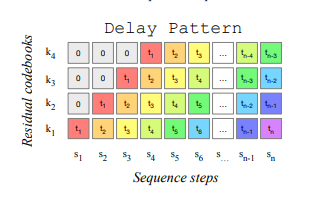


## Application of the model using huggingface

In [1]:
!nvidia-smi

Sat Jul 15 20:32:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8               6W /  61W |     98MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from transformers import MusicgenForConditionalGeneration

model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

c:\Users\Akarsh\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Akarsh\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
import torch 

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.to(device)

MusicgenForConditionalGeneration(
  (text_encoder): T5EncoderModel(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): L

### Generation without a condition 

In [14]:
unconditional = model.get_unconditional_inputs(num_samples = 1)

audio_values = model.generate(**unconditional, do_sample=True, max_new_tokens=256)

In [15]:
from IPython.display import Audio

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].cpu().numpy(), rate=sampling_rate)

### Generation with Text 

In [21]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained('facebook/musicgen-small')

prompts = processor(text = ['1990s rock music like nirvana'], padding = True,
                    return_tensors = "pt",)


audio_signals = model.generate(**prompts.to(device), do_sample = True, guidance_scale = 3, max_new_tokens = 512)

Audio(audio_signals[0].cpu().numpy(), rate=sampling_rate)

In [22]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained('facebook/musicgen-small')

prompts = processor(text = ['Heavy Metal music with a lot of drums and electric guitar'], padding = True,
                    return_tensors = "pt",)


audio_signals = model.generate(**prompts.to(device), do_sample = True, guidance_scale = 3, max_new_tokens = 512)

Audio(audio_signals[0].cpu().numpy(), rate=sampling_rate)